# MI vs Accuracy (small, fast iteration)
Quick scratch analysis to see if MI (from @logistic gamma labels) relates to final accuracy on algorithmic reasoning benchmarks using a tiny slice of data for fast iteration.



In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path

# Paths
ROOT = Path("/nlpgpu/data/terry/ToolProj")
PERF_RES = ROOT / "src" / "exps_performance" / "results"
LOGISTIC_DIR = ROOT / "src" / "exps_logistic"

# Use small row caps for speed
N_PERF = 1200  # rows from performance res.csv
N_LOGI = 800   # rows from logistic prediction CSVs



In [2]:
def load_perf_rows(n_rows: int = N_PERF):
    res_files = sorted(PERF_RES.rglob("res.csv"))
    if not res_files:
        raise FileNotFoundError("No res.csv found under src/exps_performance/results")
    # take the first file for speed
    df = pd.read_csv(res_files[0], nrows=n_rows)
    # coerce bools
    for col in ["nl_correct", "sim_correct", "controlsim_correct", "code_correct"]:
        if col in df.columns:
            df[col] = df[col].astype(bool)
    return df


def _load_logi_preds(path: Path, n_rows: int = N_LOGI):
    df = pd.read_csv(path, nrows=n_rows)
    # requires columns: rationale, true_label, pred_label, neglogp_true_nat
    df = df.rename(columns={"neglogp_true_nat": "neglogp"})
    return df


def compute_mi_from_preds(df: pd.DataFrame) -> pd.Series:
    """Variational MI lower bound in bits from predictions and true labels."""
    if "true_label" not in df.columns or "pred_label" not in df.columns:
        raise ValueError("true_label and pred_label required")
    # empirical entropy on true labels (bits)
    p_true = df["true_label"].value_counts(normalize=True)
    H = -(p_true * np.log2(p_true)).sum()
    # cross-entropy estimated with predicted probabilities for the true class
    if "neglogp" in df.columns:
        ce_nat = df["neglogp"].mean()
    else:
        # fallback: 1.0 if we only have 0/1 correctness (very rough)
        ce_nat = 1.0
    ce_bits = ce_nat / np.log(2)
    return pd.Series({"emp_entropy_bits": H, "ce_bits": ce_bits, "mi_lb_bits": H - ce_bits})



In [3]:
# Load small slices
perf_df = load_perf_rows()
logi_nl = _load_logi_preds(ROOT / "bert_nl.csv")
logi_code = _load_logi_preds(ROOT / "bert_code_tfidf.csv")  # code tfidf preds

mi_nl = compute_mi_from_preds(logi_nl)
mi_code = compute_mi_from_preds(logi_code)

mi_table = pd.DataFrame([
    {"modality": "nl", **mi_nl.to_dict()},
    {"modality": "code", **mi_code.to_dict()},
])
mi_table


,modality,emp_entropy_bits,ce_bits,mi_lb_bits
0,nl,4.762702,1.367530,3.395173
1,code,4.762702,3.503656,1.259047


In [4]:
# Aggregate accuracies per modality
acc_rows = []
for modality, col in [("nl", "nl_correct"), ("code", "sim_correct")]:
    if col not in perf_df.columns:
        continue
    acc = perf_df[col].mean()
    n = perf_df[col].notna().sum()
    acc_rows.append({"modality": modality, "accuracy": acc, "n": n})
acc_df = pd.DataFrame(acc_rows)
acc_df


,modality,accuracy,n
0,nl,0.125000,416
1,code,0.040865,416


In [5]:
# Merge MI and accuracy
merged = acc_df.merge(mi_table, on="modality", how="inner")
merged


,modality,accuracy,n,emp_entropy_bits,ce_bits,mi_lb_bits
0,nl,0.125000,416,4.762702,1.367530,3.395173
1,code,0.040865,416,4.762702,3.503656,1.259047


Pearson r (accuracy, MI_lb_bits): 1.000


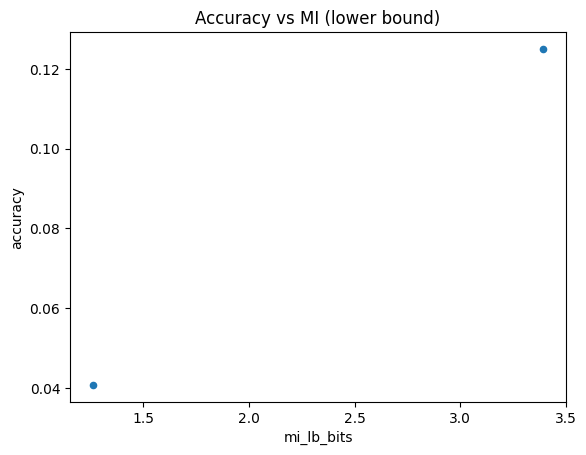

In [6]:
# Quick EDA: correlation and scatter
if len(merged):
    corr = merged["accuracy"].corr(merged["mi_lb_bits"])
    print(f"Pearson r (accuracy, MI_lb_bits): {corr:.3f}")
    merged.plot.scatter(x="mi_lb_bits", y="accuracy", title="Accuracy vs MI (lower bound)");



In [7]:
# Fit a simple GLM (binomial) with logit link: accuracy ~ MI
# Using successes/trials to respect binomial variance.
if len(merged) >= 2:
    merged["successes"] = (merged["accuracy"] * merged["n"]).round().astype(int)
    glm_df = merged[["successes", "n", "mi_lb_bits"]].copy()
    glm_df["intercept"] = 1.0
    model = sm.GLM(glm_df["successes"], glm_df[["intercept", "mi_lb_bits"]], family=sm.families.Binomial(), freq_weights=glm_df["n"])
    res = model.fit()
    print(res.summary())
else:
    print("Not enough modalities to fit model.")


                 Generalized Linear Model Regression Results                  
Dep. Variable:              successes   No. Observations:                    2
Model:                            GLM   Df Residuals:                      830
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 06 Dec 2025   Deviance:                   2.2202e+06
Time:                        10:07:49   Pearson chi2:                 5.35e+21
No. Iterations:                     2   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.015e+16   5.58e+06   -5.4e+09      0.0

/nlpgpu/data/terry/ToolProj/.venv/lib/python3.10/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/nlpgpu/data/terry/ToolProj/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/nlpgpu/data/terry/ToolProj/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1057: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights


Notes:
- Uses only a small slice (N_PERF, N_LOGI) for quick turnaround.
- MI is the variational lower bound: H(true labels) − CE(pred|true), in bits.
- Accuracy pulls nl vs sim (code) arms; swap to code_exec if needed.
- Extend by looping over all res.csv files and benchmarking MI per kind or digit if desired.
